# Implementation of Intriguing Properties of NN (TensorFlow Implementation)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


# Import initial dependancies
import numpy as np
import tensorflow as tf

tf.enable_eager_execution()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Global vars

In [3]:
weight_decay = 0
num_epochs = 10
batch_size = 128

### Data Prep 

In [4]:
# mnist_train_ds, mnist_test_ds = datasets['train'], datasets['test']
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Use tf.data to batch and shuffle the ds
mnist_train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(1024).batch(32)

mnist_test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

### Define a FC model

In [5]:
from model import FC
fc_model = FC()

### Define a Loss and Optimizer

In [6]:
# Since there are 10 different classes in this ds, define loss as categorical
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Set the metrics to measure the loss and accuracy of the model
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


### Model training

In [7]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = fc_model(images)
        loss = loss_func(labels, predictions)
    gradients = tape.gradient(loss, fc_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, fc_model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [8]:
@tf.function
def test_step(images, labels):
    predictions = fc_model(images)
    t_loss = loss_func(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [9]:
# Train the model
for epoch in range(num_epochs):
    # Reset the metrics at the start of each epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    
    
    for images, labels in mnist_train_ds:
        train_step(images, labels)
        
    for test_images, test_labels in mnist_test_ds:
        test_step(test_images, test_labels)
        
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))
    

Epoch 1, Loss: 0.25823113322257996, Accuracy: 92.67666625976562, Test Loss: 0.13606759905815125, Test Accuracy: 95.77000427246094
Epoch 2, Loss: 0.11675520986318588, Accuracy: 96.59000396728516, Test Loss: 0.10153000056743622, Test Accuracy: 96.80999755859375
Epoch 3, Loss: 0.07978732138872147, Accuracy: 97.61833190917969, Test Loss: 0.09152437001466751, Test Accuracy: 97.1199951171875
Epoch 4, Loss: 0.05883899703621864, Accuracy: 98.25999450683594, Test Loss: 0.08946008235216141, Test Accuracy: 97.20999908447266
Epoch 5, Loss: 0.0443742498755455, Accuracy: 98.73666381835938, Test Loss: 0.08694911003112793, Test Accuracy: 97.33999633789062
Epoch 6, Loss: 0.03348423168063164, Accuracy: 99.1066665649414, Test Loss: 0.08563591539859772, Test Accuracy: 97.52999877929688
Epoch 7, Loss: 0.025766009464859962, Accuracy: 99.34166717529297, Test Loss: 0.08553357422351837, Test Accuracy: 97.62999725341797
Epoch 8, Loss: 0.020372746512293816, Accuracy: 99.4766616821289, Test Loss: 0.08495876193046

In [10]:
fc_model.summary()

Model: "fc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  101770    
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


# Units of  *φ(x)*

*x′ = arg max⟨φ(x), J⟩*, where *J* is the data that was not used for training

In [28]:
def show_image(images, top_idx, vec_num):    
    fig = plt.figure(figsize=(10, 10))
    rows = 1
    cols = len(top_idx)
    for i in range(1, cols*rows + 1):
        ax = fig.add_subplot(rows, cols, i)
        ax.set_yticklabels([])
        plt.imshow(images[top_idx[i-1]])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
        


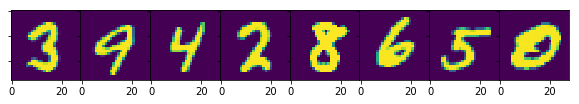

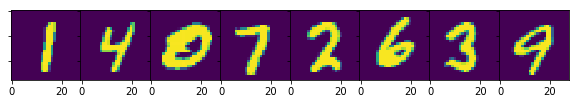

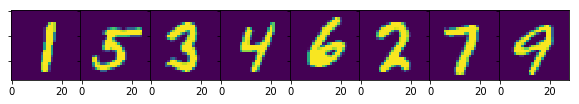

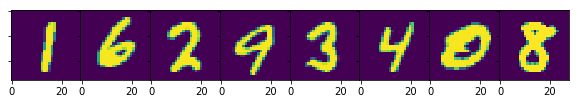

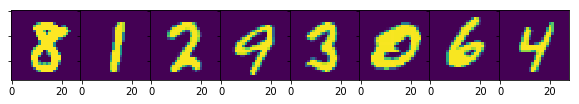

In [31]:
# Unit Vector
for i in range(5):
    unit_vec = tf.eye(128, dtype=tf.dtypes.float32)[i,:]
    
    for test_images, test_labels in mnist_test_ds:
        output = tf.cast(fc_model(test_images), 'float32')
        if (output.shape[0] == batch_size):
            values = tf.linalg.matvec(tf.transpose(output), unit_vec)
            
    top_idx = np.argsort(values.numpy())[-8:]
  
    show_image(test_images, top_idx, i)
    
    

*The plots above show the images that maximize the activations in various units. Images in each row share semantic properties with each row corresponding to the vector number (e.g. 1...5)*

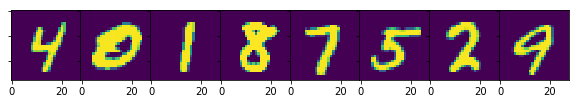

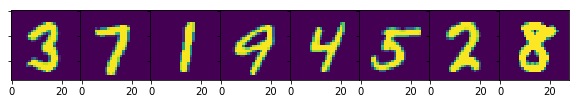

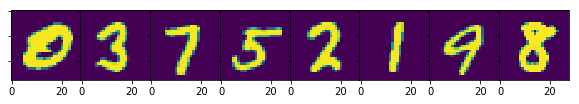

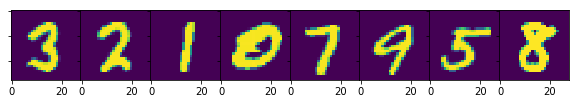

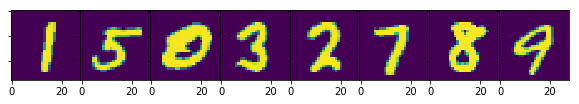

In [32]:
# Random Vector
for i in range(5):
    rand_vec = tf.cast(np.random.rand(128,), 'float32')
    
    
    for test_images, test_labels in mnist_test_ds:
        output = tf.cast(fc_model(test_images), 'float32')
        if (output.shape[0] == batch_size):
            values = tf.linalg.matvec(tf.transpose(output), rand_vec)
            
    top_idx = np.argsort(values.numpy())[-8:]
    
    show_image(test_images, top_idx, i)

*The plots above show the images that maximize the activations in random directions. Images in each row share semantic properties with each row corresponding to the vector number (e.g. 1...5)*

# Small perbertation using L-BF